In [213]:
from shapely.geometry.polygon import Polygon,Point
from shapely.geometry import MultiLineString
from shapely import points,linestrings,polygons,minimum_bounding_circle,union
from shapely import GeometryCollection, LineString, MultiPoint, Point, Polygon
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import geopandas as gpd
import shapely as shp
import xmltodict
import json
import os
from datetime import datetime
import glob
from sklearn.metrics.pairwise import haversine_distances
from scipy.ndimage import gaussian_filter
import seaborn as sns
from pyproj import CRS
import xesmf as xe

In [97]:
# set up conus mask
ds_nado=xr.open_dataset('/spcarch4/model/nadocast_grib2/20250506/nadocast_2022_models_conus_tornado_20250506_t00z_f12-35.grib2',engine='cfgrib', backend_kwargs={'indexpath':''})
ds_ndfd=xr.open_dataset('/NAWIPS/archive/OUTLOOK/2025/ndfdgrib2/torn_day1_grib2_0100_20250506010103', engine="cfgrib", backend_kwargs={'indexpath':''})

In [ ]:
ndfdnado = xe.Regridder(ds_ndfd,ds_nado, "bilinear",unmapped_to_nan=True)

In [ ]:
# CONUS mask nadocast
ds_ndfd_nado=ndfdnado(ds_ndfd)
ds_nado_test=ds_nado.copy()
ndfd_nado=ds_ndfd_nado.torprob.values
test=np.full_like(ds_ndfd_nado.torprob.values,fill_value=True,dtype='bool')
test[np.isnan(ndfd_nado)]=False
test2=test*1.0
ds_nado_test['CONUS']=(['y','x'],test2)
ds_nado_test.to_netcdf('/users/baldwin/data/CONUS_nadocast.nc')

In [2]:
# read conus mask
ds_nado_mask=xr.open_dataset('/users/baldwin/data/CONUS_nadocast.nc')


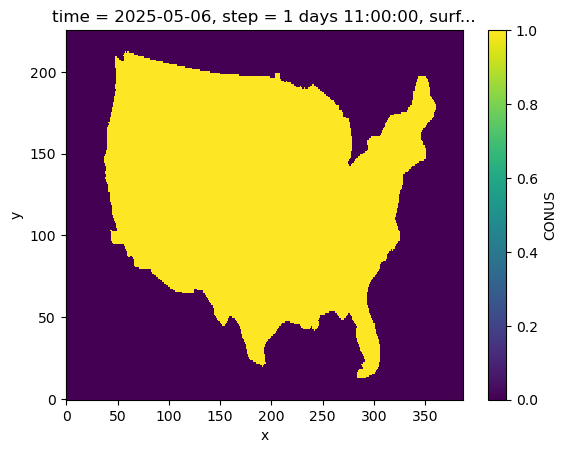

In [4]:
ds_nado_mask.CONUS.plot()

In [7]:
# distribution of forecast values
ds_nado_mask=xr.open_dataset('/users/baldwin/data/CONUS_nadocast.nc')
DATES = pd.date_range(start='2023-01-01 12:00:00',end='2025-12-31 12:00:00',inclusive='left', freq='1D')
gribfiles=[]
fname='nadocast_2022_models_conus_tornado'
for date in DATES:
    day1=date.strftime('%Y%m%d')        
    yy=date.strftime('%Y')
    #'/spcarch4/model/nadocast_grib2/20250506/nadocast_2022_models_conus_tornado_20250506_t00z_f12-35.grib2'
    gribfile=f'/spcarch4/model/nadocast_grib2/{day1}/{fname}_{day1}_t00z_f12-35.grib2'
    if (os.path.exists(gribfile)):
        gribfiles.append(gribfile)

ds_nado=xr.open_mfdataset(gribfiles,engine='cfgrib', concat_dim="valid_time", combine="nested",
                          data_vars='minimal', coords='minimal', compat='override',backend_kwargs={'indexpath':''})


In [92]:
ds_nado_mask

<xarray.Dataset> Size: 2MB
Dimensions:     (y: 226, x: 387)
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
    latitude    (y, x) float64 700kB ...
    longitude   (y, x) float64 700kB ...
    valid_time  datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Data variables:
    torprob     (y, x) float32 350kB ...
    CONUS       (y, x) float64 700kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2026-02-04T15:45 GRIB to CDM+CF via cfgrib-0.9.1...

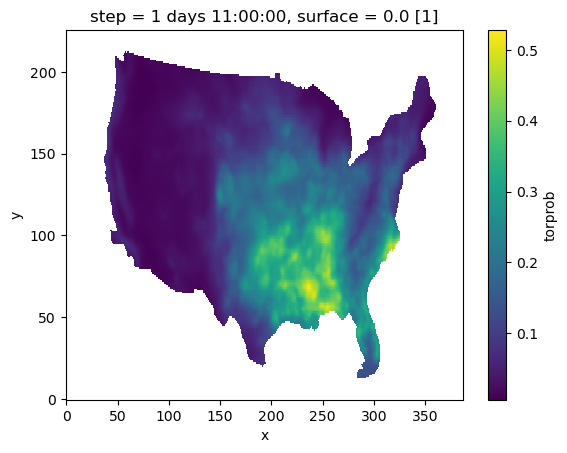

In [35]:
# units of %
ds_nado.where(ds_nado_mask.CONUS>0.).torprob.mean(dim='valid_time').plot()

<Axes: ylabel='Density'>

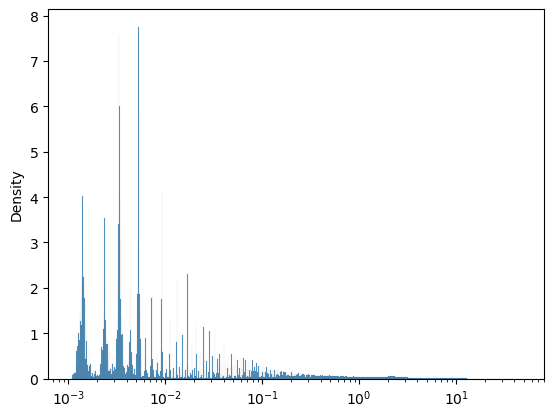

In [11]:
# there are no zeros, min value is 0.001 this could be due to grib packing
probs=ds_nado.where(ds_nado_mask.CONUS>0.).torprob.values.flatten()
sns.histplot(probs[probs>0],stat='density',log_scale=True)

<Axes: ylabel='Density'>

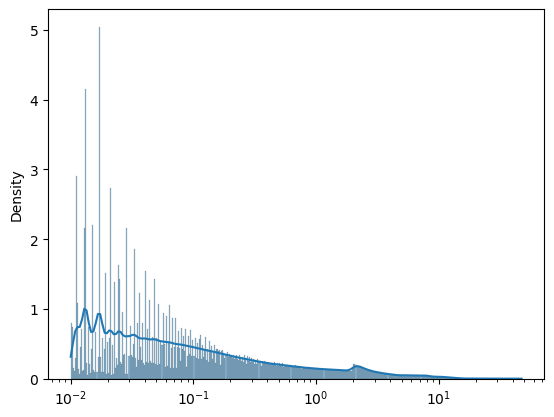

In [33]:
# nadocast torprob are in units of %
# spiky distribution is probably due to grib packing
sns.histplot(probs[probs>=0.01],stat='density',log_scale=True,kde=True)

In [34]:
np.mean(probs[probs>=-1.e-3])

0.12747239

In [36]:
np.nanmin(probs)

0.0010613332

In [37]:
df_wind_all=pd.read_csv('/users/baldwin/Downloads/1955-2024_wind.csv')
df_wind=df_wind_all[(df_wind_all.yr>=2023)].copy()
df_wind['datetime']=pd.to_datetime(df_wind.date+' '+df_wind.time)+pd.Timedelta('6 hours')
df_wind_measvr=df_wind[((df_wind.mt=='MG')|(df_wind.mt=='MS'))&(df_wind.mag>=50.0)].filter(items=['datetime','slon','slat','mag'])
del df_wind_all

df_torn_all=pd.read_csv('/users/baldwin/Downloads/1950-2024_torn.csv')
df_torn=df_torn_all[df_torn_all.yr>=2023].copy()
df_torn['datetime']=pd.to_datetime(df_torn.date+' '+df_torn.time)+pd.Timedelta('6 hours')
df_torn_paths=df_torn[(df_torn.len>0.)&(df_torn.elat>0.)]
#df_torn_pts=df_torn[(df_torn.len==0.)|((df_torn.len>0.)&(df_torn.elat==0.))].filter(items=['datetime','slon','slat','mag'])
del df_torn_all


df_hail_all=pd.read_csv('/users/baldwin/Downloads/1955-2024_hail.csv')
df_hail=df_hail_all[(df_hail_all.yr>=2023)].copy()
df_hail['datetime']=pd.to_datetime(df_hail.date+' '+df_hail.time)+pd.Timedelta('6 hours')
df_hail_svr=df_hail[df_hail.mag>=1.0].filter(items=['datetime','slon','slat','mag'])
del df_hail_all

#turn tornado paths into a series of points for pph
ntot=df_torn_paths.shape[0]
slats=df_torn_paths.sort_values(by='len').slat.to_numpy()
slons=df_torn_paths.sort_values(by='len').slon.to_numpy()
elats=df_torn_paths.sort_values(by='len').elat.to_numpy()
elons=df_torn_paths.sort_values(by='len').elon.to_numpy()
dates=df_torn_paths.sort_values(by='len').datetime.to_numpy()
mags=df_torn_paths.sort_values(by='len').mag.to_numpy()
path_lats=np.zeros(ntot*11)
path_lons=np.zeros(ntot*11)
path_dates=np.zeros(ntot*11)
path_mag=np.zeros(ntot*11)
for j in np.arange(ntot):
    path_lats[j*11:(j+1)*11]=np.linspace(slats[j],elats[j],11)
    path_lons[j*11:(j+1)*11]=np.linspace(slons[j],elons[j],11)
    path_dates[j*11:(j+1)*11]=dates[j]
    path_mag[j*11:(j+1)*11]=mags[j]
df_torn_pathpts=pd.DataFrame({'datetime':path_dates,'slon':path_lons,'slat':path_lats,'mag':path_mag})
df_torn_pathpts['datetime']=pd.to_datetime(df_torn_pathpts.datetime)

df_allsvr=pd.concat([df_wind_measvr,df_hail_svr,df_torn_pathpts])
df_all=pd.concat([df_wind,df_hail,df_torn_pathpts])

/tmp/ipykernel_311928/1138515784.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_wind_all=pd.read_csv('/users/baldwin/Downloads/1955-2024_wind.csv')
/tmp/ipykernel_311928/1138515784.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind['datetime']=pd.to_datetime(df_wind.date+' '+df_wind.time)+pd.Timedelta('6 hours')
/tmp/ipykernel_311928/1138515784.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_torn['datetime']=pd.to_datetime(df_t

In [50]:
df_torn[df_torn.date=='2023-03-24'].iloc[2]

om                       622315
yr                         2023
mo                            3
dy                           24
date                 2023-03-24
time                   18:57:00
tz                            3
st                           MS
stf                          28
stn                           0
mag                           4
inj                         165
fat                          17
loss                 96430000.0
closs                  214200.0
slat                      32.84
slon                      -91.0
elat                      33.26
elon                     -90.11
len                       59.23
wid                        1320
ns                            1
sn                            1
sg                            1
f1                           55
f2                          125
f3                           53
f4                           51
fc                            0
datetime    2023-03-25 00:57:00
Name: 70321, dtype: object

In [45]:
day1=230324
fld='torn'
df_rept=pd.read_csv(f'https://www.spc.noaa.gov/climo/reports/{day1}_rpts_{fld}.csv')

In [51]:
df_rept.iloc[0]

Time                                                       57
F_Scale                                                   UNK
Location                                     5 SE MAYERSVILLE
County                                              ISSAQUENA
State                                                      MS
Lat                                                     32.84
Lon                                                     -91.0
Comments    *** 16 FATAL *** A LONG TRACK EF4 TORNADO DEVE...
Name: 0, dtype: object

In [128]:
df_storm=pd.read_csv('/users/baldwin/Downloads/StormEvents_details-ftp_v1.0_d2025_c20260116.csv.gz')

df_tornado=df_storm[df_storm.EVENT_TYPE=='Tornado'].copy()
df_tornado['begin_datetime']=pd.to_datetime(df_tornado.BEGIN_DATE_TIME,format='%d-%b-%y %H:%M:%S')
df_tornado['end_datetime']=pd.to_datetime(df_tornado.END_DATE_TIME,format='%d-%b-%y %H:%M:%S')
df_tornado['duration']=df_tornado.end_datetime-df_tornado.begin_datetime
df_torn_ast=df_tornado[df_tornado.CZ_TIMEZONE=='AST-4'].copy()
df_torn_est=df_tornado[df_tornado.CZ_TIMEZONE=='EST-5'].copy()
df_torn_cst=df_tornado[df_tornado.CZ_TIMEZONE=='CST-6'].copy()
df_torn_mst=df_tornado[df_tornado.CZ_TIMEZONE=='MST-7'].copy()
df_torn_pst=df_tornado[df_tornado.CZ_TIMEZONE=='PST-8'].copy()
df_torn_akst=df_tornado[df_tornado.CZ_TIMEZONE=='AKST-9'].copy()
df_torn_ast['begin_datetime']+=pd.Timedelta('4 hours')
df_torn_ast['end_datetime']+=pd.Timedelta('4 hours')
df_torn_est['begin_datetime']+=pd.Timedelta('5 hours')
df_torn_est['end_datetime']+=pd.Timedelta('5 hours')
df_torn_cst['begin_datetime']+=pd.Timedelta('6 hours')
df_torn_cst['end_datetime']+=pd.Timedelta('6 hours')
df_torn_mst['begin_datetime']+=pd.Timedelta('7 hours')
df_torn_mst['end_datetime']+=pd.Timedelta('7 hours')
df_torn_pst['begin_datetime']+=pd.Timedelta('8 hours')
df_torn_pst['end_datetime']+=pd.Timedelta('8 hours')
df_torn_akst['begin_datetime']+=pd.Timedelta('9 hours')
df_torn_akst['end_datetime']+=pd.Timedelta('9 hours')
df_torn_utc=pd.concat([df_torn_ast,df_torn_est,df_torn_cst,df_torn_pst,df_torn_akst])
df_torn_utc['begin_hour_top']=df_torn_utc.begin_datetime.dt.ceil('h')
df_torn_utc['end_hour_top']=df_torn_utc.end_datetime.dt.ceil('h')

df_multihour=df_torn_utc[df_torn_utc['begin_hour_top']!=df_torn_utc['end_hour_top']]
df_singlehour=df_torn_utc[df_torn_utc['begin_hour_top']==df_torn_utc['end_hour_top']]

all_dfs=[]
for i in np.arange(len(df_multihour)):
    selected_row=df_multihour.iloc[i]
    datetimes=pd.date_range(start=selected_row.begin_datetime,end=selected_row.end_datetime,freq='s')
    dftest=pd.DataFrame({'lat':np.full(len(datetimes),np.nan),'lon':np.full(len(datetimes),np.nan)},index=datetimes)
    hour_tops=datetimes.ceil('h').unique()
    dftest.loc[selected_row.begin_datetime,'lat']=selected_row.BEGIN_LAT
    dftest.loc[selected_row.begin_datetime,'lon']=selected_row.BEGIN_LON
    dftest.loc[selected_row.end_datetime,'lat']=selected_row.END_LAT
    dftest.loc[selected_row.end_datetime,'lon']=selected_row.END_LON
    df_interp=dftest.interpolate(method='time').reset_index(names='datetime')
    df_new=pd.DataFrame([selected_row]*len(hour_tops))
    row=0
    for hour in hour_tops:
        df_new.iloc[row,44]=df_interp[df_interp.datetime.dt.ceil('h')==hour].iloc[0].lat
        df_new.iloc[row,45]=df_interp[df_interp.datetime.dt.ceil('h')==hour].iloc[0].lon
        df_new.iloc[row,51]=df_interp[df_interp.datetime.dt.ceil('h')==hour].iloc[0].datetime
        df_new.iloc[row,46]=df_interp[df_interp.datetime.dt.ceil('h')==hour].iloc[-1].lat
        df_new.iloc[row,47]=df_interp[df_interp.datetime.dt.ceil('h')==hour].iloc[-1].lon
        df_new.iloc[row,52]=df_interp[df_interp.datetime.dt.ceil('h')==hour].iloc[-1].datetime
        row=row+1
        
    all_dfs.append(df_new)

df_split_hours=pd.concat(all_dfs,ignore_index=True)
df_torn_final=pd.concat([df_singlehour,df_split_hours],ignore_index=True)
df_torn_final['begin_hour_top']=df_torn_final.begin_datetime.dt.ceil('h')
df_torn_final['end_hour_top']=df_torn_final.end_datetime.dt.ceil('h')
df_torn_final.loc[df_torn_final.TOR_F_SCALE=='EFU','MAGNITUDE']=-1.
df_torn_final.loc[df_torn_final.TOR_F_SCALE=='EF0','MAGNITUDE']=0.
df_torn_final.loc[df_torn_final.TOR_F_SCALE=='EF1','MAGNITUDE']=1.
df_torn_final.loc[df_torn_final.TOR_F_SCALE=='EF2','MAGNITUDE']=2.
df_torn_final.loc[df_torn_final.TOR_F_SCALE=='EF3','MAGNITUDE']=3.
df_torn_final.loc[df_torn_final.TOR_F_SCALE=='EF4','MAGNITUDE']=4.
df_torn_final.loc[df_torn_final.TOR_F_SCALE=='EF5','MAGNITUDE']=5.
#df_ef1_ef5=df_torn_final[~((df_torn_final.TOR_F_SCALE=='EFU')|(df_torn_final.TOR_F_SCALE=='EF0'))]
df_torn=df_torn_final.filter(items=['MAGNITUDE','end_hour_top','BEGIN_LON','BEGIN_LAT','END_LON','END_LAT'])
df_torn.rename(columns={'MAGNITUDE':'mag','end_hour_top':'datetime','BEGIN_LON':'slon','BEGIN_LAT':'slat','END_LON':'elon','END_LAT':'elat'},inplace=True)
df_ef1_ef5=df_torn[df_torn.mag>=1.].copy()

#df_torn_final.to_csv('/users/baldwin/datasets/torn_seg_hour_2025.csv')

In [130]:
df_torn

,mag,datetime,slon,slat,elon,elat
0,1.0,2025-03-30 21:00:00,-86.100000,41.790000,-86.070000,41.820000
1,1.0,2025-03-16 16:00:00,-82.458000,30.279000,-82.452400,30.280900
2,0.0,2025-09-06 21:00:00,-71.929200,42.317000,-71.926100,42.317700
3,0.0,2025-09-06 21:00:00,-71.890400,42.321600,-71.888300,42.322600
4,0.0,2025-03-31 20:00:00,-84.184900,30.369800,-84.153200,30.367000
...,...,...,...,...,...,...
1637,1.0,2025-06-06 13:00:00,-94.911445,35.488263,-94.885900,35.486200
1638,1.0,2025-06-09 03:00:00,-96.246800,33.646200,-96.198689,33.608922
1639,1.0,2025-06-09 04:00:00,-96.198529,33.608798,-96.160200,33.579100
1640,-1.0,2025-09-15 00:00:00,-100.710000,48.179000,-100.721667,48.182333


In [129]:
df_wind=df_storm[df_storm.EVENT_TYPE=='Thunderstorm Wind'].copy()
df_wind['begin_datetime']=pd.to_datetime(df_wind.BEGIN_DATE_TIME,format='%d-%b-%y %H:%M:%S')
df_wind['end_datetime']=pd.to_datetime(df_wind.END_DATE_TIME,format='%d-%b-%y %H:%M:%S')
df_wind['duration']=df_wind.end_datetime-df_wind.begin_datetime
df_wind_ast=df_wind[df_wind.CZ_TIMEZONE=='AST-4'].copy()
df_wind_est=df_wind[df_wind.CZ_TIMEZONE=='EST-5'].copy()
df_wind_cst=df_wind[df_wind.CZ_TIMEZONE=='CST-6'].copy()
df_wind_mst=df_wind[df_wind.CZ_TIMEZONE=='MST-7'].copy()
df_wind_pst=df_wind[df_wind.CZ_TIMEZONE=='PST-8'].copy()
df_wind_akst=df_wind[df_wind.CZ_TIMEZONE=='AKST-9'].copy()
df_wind_ast['begin_datetime']+=pd.Timedelta('4 hours')
df_wind_ast['end_datetime']+=pd.Timedelta('4 hours')
df_wind_est['begin_datetime']+=pd.Timedelta('5 hours')
df_wind_est['end_datetime']+=pd.Timedelta('5 hours')
df_wind_cst['begin_datetime']+=pd.Timedelta('6 hours')
df_wind_cst['end_datetime']+=pd.Timedelta('6 hours')
df_wind_mst['begin_datetime']+=pd.Timedelta('7 hours')
df_wind_mst['end_datetime']+=pd.Timedelta('7 hours')
df_wind_pst['begin_datetime']+=pd.Timedelta('8 hours')
df_wind_pst['end_datetime']+=pd.Timedelta('8 hours')
df_wind_akst['begin_datetime']+=pd.Timedelta('9 hours')
df_wind_akst['end_datetime']+=pd.Timedelta('9 hours')
df_wind_utc=pd.concat([df_wind_ast,df_wind_est,df_wind_cst,df_wind_pst,df_wind_akst])
df_wind_utc['begin_hour_top']=df_wind_utc.begin_datetime.dt.ceil('h')
df_wind_utc['end_hour_top']=df_wind_utc.end_datetime.dt.ceil('h')

df_multihour=df_wind_utc[df_wind_utc['begin_hour_top']!=df_wind_utc['end_hour_top']]
df_singlehour=df_wind_utc[df_wind_utc['begin_hour_top']==df_wind_utc['end_hour_top']]

all_dfs=[]
for i in np.arange(len(df_multihour)):
    selected_row=df_multihour.iloc[i]
    datetimes=pd.date_range(start=selected_row.begin_datetime,end=selected_row.end_datetime,freq='s')
    dftest=pd.DataFrame({'lat':np.full(len(datetimes),np.nan),'lon':np.full(len(datetimes),np.nan)},index=datetimes)
    hour_tops=datetimes.ceil('h').unique()
    dftest.loc[selected_row.begin_datetime,'lat']=selected_row.BEGIN_LAT
    dftest.loc[selected_row.begin_datetime,'lon']=selected_row.BEGIN_LON
    dftest.loc[selected_row.end_datetime,'lat']=selected_row.END_LAT
    dftest.loc[selected_row.end_datetime,'lon']=selected_row.END_LON
    df_interp=dftest.interpolate(method='time').reset_index(names='datetime')
    df_new=pd.DataFrame([selected_row]*len(hour_tops))
    row=0
    for hour in hour_tops:
        df_new.iloc[row,44]=df_interp[df_interp.datetime.dt.ceil('h')==hour].iloc[0].lat
        df_new.iloc[row,45]=df_interp[df_interp.datetime.dt.ceil('h')==hour].iloc[0].lon
        df_new.iloc[row,51]=df_interp[df_interp.datetime.dt.ceil('h')==hour].iloc[0].datetime
        df_new.iloc[row,46]=df_interp[df_interp.datetime.dt.ceil('h')==hour].iloc[-1].lat
        df_new.iloc[row,47]=df_interp[df_interp.datetime.dt.ceil('h')==hour].iloc[-1].lon
        df_new.iloc[row,52]=df_interp[df_interp.datetime.dt.ceil('h')==hour].iloc[-1].datetime
        row=row+1
        
    all_dfs.append(df_new)

df_split_hours=pd.concat(all_dfs,ignore_index=True)
df_wind_final=pd.concat([df_singlehour,df_split_hours],ignore_index=True)
df_wind_final['begin_hour_top']=df_wind_final.begin_datetime.dt.ceil('h')
df_wind_final['end_hour_top']=df_wind_final.end_datetime.dt.ceil('h')
df_wind_svr=df_wind_final[df_wind_final.MAGNITUDE>=50.]
df_wind_measvr=df_wind_svr[((df_wind_svr.MAGNITUDE_TYPE=='MG')|(df_wind_svr.MAGNITUDE_TYPE=='MS'))].filter(items=['MAGNITUDE','end_hour_top','BEGIN_LON','BEGIN_LAT','END_LON','END_LAT'])
df_wind=df_wind_svr.filter(items=['MAGNITUDE','end_hour_top','BEGIN_LON','BEGIN_LAT','END_LON','END_LAT'])
df_wind.rename(columns={'MAGNITUDE':'mag','end_hour_top':'datetime','BEGIN_LON':'slon','BEGIN_LAT':'slat','END_LON':'elon','END_LAT':'elat'},inplace=True)
df_wind_measvr.rename(columns={'MAGNITUDE':'mag','end_hour_top':'datetime','BEGIN_LON':'slon','BEGIN_LAT':'slat','END_LON':'elon','END_LAT':'elat'},inplace=True)

In [127]:
df_wind

,mag,datetime,slon,slat,elon,elat
55,52.0,2025-10-24 21:00:00,-66.749500,18.068300,-66.7495,18.0683
62,52.0,2025-03-31 17:00:00,-85.238000,33.475700,-85.2380,33.4757
63,60.0,2025-03-16 18:00:00,-79.090000,40.540000,-79.0900,40.5400
64,50.0,2025-03-16 18:00:00,-80.575300,40.894100,-80.5753,40.8941
65,50.0,2025-03-16 17:00:00,-79.710000,40.030000,-79.7100,40.0300
...,...,...,...,...,...,...
19983,60.0,2025-10-14 16:00:00,-118.045299,34.273000,-118.0451,34.2731
19988,70.0,2025-09-02 17:00:00,-121.352000,38.649000,-121.3520,38.6490
19989,70.0,2025-09-02 18:00:00,-121.351994,38.649009,-121.3300,38.6830
19990,63.0,2025-06-16 23:00:00,-134.393300,58.286200,-134.3933,58.2862


In [120]:
df_hail=df_storm[df_storm.EVENT_TYPE=='Hail'].copy()
df_hail['begin_datetime']=pd.to_datetime(df_hail.BEGIN_DATE_TIME,format='%d-%b-%y %H:%M:%S')
df_hail['end_datetime']=pd.to_datetime(df_hail.END_DATE_TIME,format='%d-%b-%y %H:%M:%S')
df_hail['duration']=df_hail.end_datetime-df_hail.begin_datetime
df_hail_ast=df_hail[df_hail.CZ_TIMEZONE=='AST-4'].copy()
df_hail_est=df_hail[df_hail.CZ_TIMEZONE=='EST-5'].copy()
df_hail_cst=df_hail[df_hail.CZ_TIMEZONE=='CST-6'].copy()
df_hail_mst=df_hail[df_hail.CZ_TIMEZONE=='MST-7'].copy()
df_hail_pst=df_hail[df_hail.CZ_TIMEZONE=='PST-8'].copy()
df_hail_akst=df_hail[df_hail.CZ_TIMEZONE=='AKST-9'].copy()
df_hail_ast['begin_datetime']+=pd.Timedelta('4 hours')
df_hail_ast['end_datetime']+=pd.Timedelta('4 hours')
df_hail_est['begin_datetime']+=pd.Timedelta('5 hours')
df_hail_est['end_datetime']+=pd.Timedelta('5 hours')
df_hail_cst['begin_datetime']+=pd.Timedelta('6 hours')
df_hail_cst['end_datetime']+=pd.Timedelta('6 hours')
df_hail_mst['begin_datetime']+=pd.Timedelta('7 hours')
df_hail_mst['end_datetime']+=pd.Timedelta('7 hours')
df_hail_pst['begin_datetime']+=pd.Timedelta('8 hours')
df_hail_pst['end_datetime']+=pd.Timedelta('8 hours')
df_hail_akst['begin_datetime']+=pd.Timedelta('9 hours')
df_hail_akst['end_datetime']+=pd.Timedelta('9 hours')
df_hail_utc=pd.concat([df_hail_ast,df_hail_est,df_hail_cst,df_hail_pst,df_hail_akst])
df_hail_utc['begin_hour_top']=df_hail_utc.begin_datetime.dt.ceil('h')
df_hail_utc['end_hour_top']=df_hail_utc.end_datetime.dt.ceil('h')

df_multihour=df_hail_utc[df_hail_utc['begin_hour_top']!=df_hail_utc['end_hour_top']]
df_singlehour=df_hail_utc[df_hail_utc['begin_hour_top']==df_hail_utc['end_hour_top']]

all_dfs=[]
for i in np.arange(len(df_multihour)):
    selected_row=df_multihour.iloc[i]
    datetimes=pd.date_range(start=selected_row.begin_datetime,end=selected_row.end_datetime,freq='s')
    dftest=pd.DataFrame({'lat':np.full(len(datetimes),np.nan),'lon':np.full(len(datetimes),np.nan)},index=datetimes)
    hour_tops=datetimes.ceil('h').unique()
    dftest.loc[selected_row.begin_datetime,'lat']=selected_row.BEGIN_LAT
    dftest.loc[selected_row.begin_datetime,'lon']=selected_row.BEGIN_LON
    dftest.loc[selected_row.end_datetime,'lat']=selected_row.END_LAT
    dftest.loc[selected_row.end_datetime,'lon']=selected_row.END_LON
    df_interp=dftest.interpolate(method='time').reset_index(names='datetime')
    df_new=pd.DataFrame([selected_row]*len(hour_tops))
    row=0
    for hour in hour_tops:
        df_new.iloc[row,44]=df_interp[df_interp.datetime.dt.ceil('h')==hour].iloc[0].lat
        df_new.iloc[row,45]=df_interp[df_interp.datetime.dt.ceil('h')==hour].iloc[0].lon
        df_new.iloc[row,51]=df_interp[df_interp.datetime.dt.ceil('h')==hour].iloc[0].datetime
        df_new.iloc[row,46]=df_interp[df_interp.datetime.dt.ceil('h')==hour].iloc[-1].lat
        df_new.iloc[row,47]=df_interp[df_interp.datetime.dt.ceil('h')==hour].iloc[-1].lon
        df_new.iloc[row,52]=df_interp[df_interp.datetime.dt.ceil('h')==hour].iloc[-1].datetime
        row=row+1
        
    all_dfs.append(df_new)

df_split_hours=pd.concat(all_dfs,ignore_index=True)
df_hail_final=pd.concat([df_singlehour,df_split_hours],ignore_index=True)
df_hail_final['begin_hour_top']=df_hail_final.begin_datetime.dt.ceil('h')
df_hail_final['end_hour_top']=df_hail_final.end_datetime.dt.ceil('h')
df_hail_svr=df_hail_final[df_hail_final.MAGNITUDE>=1.]
df_hail=df_hail_svr.filter(items=['MAGNITUDE','end_hour_top','BEGIN_LON','BEGIN_LAT','END_LON','END_LAT'])
df_hail.rename(columns={'MAGNITUDE':'mag','end_hour_top':'datetime','BEGIN_LON':'slon','BEGIN_LAT':'slat','END_LON':'elon','END_LAT':'elat'},inplace=True)

In [122]:
#df_torn_final.loc[1]

df_hail.iloc[1]

mag                         1.0
datetime    2025-04-29 21:00:00
slon                     -77.61
slat                      42.91
elon                     -77.61
elat                      42.91
Name: 3, dtype: object

In [196]:
ds_mask=xr.open_dataset('/users/baldwin/data/CONUS_nadocast.nc')
conus_grid=ds_mask.CONUS.values
xx_mlp=np.arange(226)
yy_mlp=np.arange(387)
Xhw,Yhw=np.meshgrid(xx_mlp,yy_mlp)
X1dhw=Xhw.flatten()
Y1dhw=Yhw.flatten()
lat2d=ds_mask.latitude.values
lon2d=ds_mask.longitude.values-360.0
df_hwgrd=pd.DataFrame({'col':X1dhw,'row':Y1dhw,'conus':conus_grid.flatten(),'lon':lon2d.flatten(),'lat':lat2d.flatten()})
hwgrdlatlon = gpd.GeoDataFrame(df_hwgrd, geometry=gpd.points_from_xy(df_hwgrd.lon, df_hwgrd.lat)).set_crs(epsg=4326)
hwgrdproj=hwgrdlatlon.to_crs(crs=CRS.from_proj4("+proj=lcc +lat_1=25 +lat_2=25 +lon_0=-95"))
hwgrdproj['geometry']=hwgrdproj.buffer(7620.,cap_style='square')
hwgrd = hwgrdproj.to_crs('epsg:4087')

In [395]:
# MEB 23 Feb 2026
# verify nadocast using polygons (polygons created in another script do_nadocast_to_geojson)
# add stats needed to calculate MSE
# do regional verf use bukvosky regions
# use projection lcc with precision = 1.
# polygon-based area add buffer around obs

areaempty=shp.Polygon()




DATES = pd.date_range(start='2025-01-01 12:00:00',end='2025-11-01 12:00:00',inclusive='left', freq='1D')
#DATES = pd.date_range(start='2025-03-15 12:00:00',end='2025-03-15 12:00:00',inclusive='left', freq='1D')


usa=gpd.read_file('/users/baldwin/datasets/usa_outline.geojson').set_crs(epsg=4326)
region_bukovsky=gpd.read_file('/users/baldwin/datasets/bukovsky_regions_groups.geojson').set_crs(epsg=4326)
regions=region_bukovsky.copy()
regions['geometry']=region_bukovsky.set_precision(0.0001).to_crs(crs=CRS.from_proj4("+proj=lcc +lat_1=25 +lat_2=25 +lon_0=-95")).set_precision(1.)

#regions=gpd.read_file('/users/baldwin/datasets/bukovsky_cwa_regions_groups.geojson')

ranges=['climo']

#flds=['wind']
#obstype=['all','svr','meas','sigall','sigmeas']

flds=['torn','hail','wind']


#flds=['torn','wind','hail']

for fld in flds:
    print(fld)
    # prob levels areas intersections unions
    #pd.DataFrame({'OUTLOOK':prod_lvl,'VALID':valid_lvl,'EXPIRE':expire_lvl,'ISSUE':issue_lvl,'LABEL':label,
    #'FAREA':farea,'XAREA':xarea,'SIGAREA':sigarea,'INTERSECT':intersect,'UNION':union})
    fld_lvl=[]
    prod_lvl=[]
    cig_lvl=[]
    valid_lvl=[]
    expire_lvl=[]
    issue_lvl=[]
    obs_type=[]
    region_lvl=[]
    region_name=[]
    label=[]
    farea=[]
    xarea=[]
    sigarea=[]
    intersect=[]
    union=[]
    domain=[]
    aa=[]
    bb=[]
    cc=[]
    dd=[]
    rel_farea=[]
    rel_intersect=[]
    fld_lvl_mse=[]
    prod_lvl_mse=[]
    valid_lvl_mse=[]
    expire_lvl_mse=[]
    issue_lvl_mse=[]
    obs_type_mse=[]
    region_lvl_mse=[]
    region_name_mse=[]
    xarea_mse=[]
    domain_mse=[]
    e_f=[]
    e_f2=[]
    e_fx=[]
    e_x=[]
    

    if fld=='torn':
        lvls=np.array([0.,1.e-4,1.e-3,.01,.02,.05,.10,.15,.20,.25,.30,.45,.6])
        nlvls=13
        obstype=['svr','sigall']
        fname='nadocast_2022_models_conus_tornado'
    elif fld=='hail':
        lvls=np.array([0.,1.e-4,1.e-3,.01,.02,.05,.10,.15,.20,.25,.30,.45,.6])
        nlvls=13
        obstype=['svr','sigall']
        fname='nadocast_2022_models_conus_hail'
    elif fld=='wind':
        lvls=np.array([0.,1.e-4,1.e-3,.01,.02,.05,.10,.15,.20,.25,.30,.45,.6])
        nlvls=13
        obstype=['all','meas','svr','sigall','sigmeas']
        fname='nadocast_2022_models_conus_wind'

    title_lvl=[]
    for ii in np.arange(nlvls):
        lvl=lvls[ii]
        title_lvl.append(str(lvl*100.))
        
    for date in DATES:
        if date.is_leap_year:
            jjj=date.strftime('%j')
        else:
            if date.month>=3:
                jjj=(date+pd.to_timedelta('1 day')).strftime('%j')
            else:
                jjj=date.strftime('%j')
        print(date,jjj,datetime.now())
        for range in ranges:
            if len(aa)<len(domain):
                print(' oops ',date,range,fld)
                sys.exit()
            ffld=f'{fld}_{range}'
            if fld=='hail':
                sigthr=2.0
                svrthr=1.0
            if fld=='wind':
                sigthr=64.
                svrthr=50.
            if fld=='torn':
                sigthr=2.
                svrthr=-10.
    
            day1=date.strftime('%Y%m%d')        
            yy=date.strftime('%Y')  
            valid_time=date
            expire_time=date+pd.to_timedelta('1 day')
            issue_time=date-pd.to_timedelta('12 hours')

            try:
                jsonfile1=f'/scratch/baldwin/nadocast/{fname}_{day1}_t00z_f12-35.geojson'
                prodproj=gpd.read_file(jsonfile1)
                prodproj['geometry']=prodproj['geometry'].fillna(shp.Polygon())
            except:
                #print(f'/NAWIPS/archive/OUTLOOK/{yy}/geojson/{ffld}_{day1}*.lyr.geojson file not found')
                print(jsonfile1,'some kind of error')

                continue

            verfdomain_full=shp.set_precision(usa.to_crs(crs=CRS.from_proj4("+proj=lcc +lat_1=25 +lat_2=25 +lon_0=-95")).geometry,grid_size=1.).iloc[0]
            fcst_nonzero=shp.unary_union(prodproj.geometry.iloc[0:]).buffer(10000.).buffer(-10000.).simplify(tolerance=1000, preserve_topology=True)
            prodproj.loc[nlvls-1,'geometry']=shp.difference(verfdomain_full,fcst_nonzero)
            prodproj.loc[nlvls-1,'title']='0.00'
            prodproj.loc[nlvls-1,'mlp']=0.
            for obs1 in obstype:
                if obs1 == 'all':
                    if fld=='hail':
                        df_today=df_hail[(df_hail.datetime>=valid_time)&(df_hail.datetime<=expire_time)]
                    if fld=='wind':
                        df_today=df_wind[(df_wind.datetime>=valid_time)&(df_wind.datetime<=expire_time)]
                    if fld=='torn':
                        df_today=df_torn[(df_torn.datetime>=valid_time)&(df_torn.datetime<=expire_time)]
                elif obs1 == 'meas':
                    if fld=='hail':
                        df_today=df_hail[(df_hail.datetime>=valid_time)&(df_hail.datetime<=expire_time)]
                    if fld=='wind':
                        df_today=df_wind_measvr[(df_wind_measvr.datetime>=valid_time)&(df_wind_measvr.datetime<=expire_time)]
                    if fld=='torn':
                        df_today=df_torn[(df_torn.datetime>=valid_time)&(df_torn.datetime<=expire_time)]
                elif obs1 == 'svr':
                    if fld=='hail':
                        df_today=df_hail[(df_hail.mag>=svrthr)&(df_hail.datetime>=valid_time)&(df_hail.datetime<=expire_time)]
                    if fld=='wind':
                        df_today=df_wind[(df_wind.mag>=svrthr)&(df_wind.datetime>=valid_time)&(df_wind.datetime<=expire_time)]
                    if fld=='torn':
                        df_today=df_torn[(df_torn.mag>=svrthr)&(df_torn.datetime>=valid_time)&(df_torn.datetime<=expire_time)]
                elif obs1 == 'sigall':
                    if fld=='hail':
                        df_today=df_hail[(df_hail.mag>=sigthr)&(df_hail.datetime>=valid_time)&(df_hail.datetime<=expire_time)]
                    if fld=='wind':
                        df_today=df_wind[(df_wind.mag>=sigthr)&(df_wind.datetime>=valid_time)&(df_wind.datetime<=expire_time)]
                    if fld=='torn':
                        df_today=df_torn[(df_torn.mag>=sigthr)&(df_torn.datetime>=valid_time)&(df_torn.datetime<=expire_time)]
                elif obs1 == 'sigmeas':
                    if fld=='hail':
                        df_today=df_hail[(df_hail.mag>=sigthr)&(df_hail.datetime>=valid_time)&(df_hail.datetime<=expire_time)]
                    if fld=='wind':
                        df_today=df_wind_measvr[(df_wind_measvr.mag>=sigthr)&(df_wind_measvr.datetime>=valid_time)&(df_wind_measvr.datetime<=expire_time)]
                    if fld=='torn':
                        df_today=df_torn[(df_torn.mag>=sigthr)&(df_torn.datetime>=valid_time)&(df_torn.datetime<=expire_time)]
                df1=df_today.copy()
                if df1.shape[0]>0:
                    if fld=='torn':
                        startlatlon = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.slon, df1.slat)).set_crs(epsg=4326)
                        endlatlon = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.elon, df1.elat)).set_crs(epsg=4326)
                        gdfstart=startlatlon.to_crs(crs=CRS.from_proj4("+proj=lcc +lat_1=25 +lat_2=25 +lon_0=-95"))
                        gdfend=endlatlon.to_crs(crs=CRS.from_proj4("+proj=lcc +lat_1=25 +lat_2=25 +lon_0=-95"))
                        gdf=gpd.GeoDataFrame(df1, geometry=gdfstart.geometry.shortest_line(gdfend.geometry))
                    else:
                        gdflatlon = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.slon, df1.slat)).set_crs(epsg=4326)
                        gdf = gdflatlon.to_crs(crs=CRS.from_proj4("+proj=lcc +lat_1=25 +lat_2=25 +lon_0=-95"))
                    obsarea_full=shp.set_precision(shp.union_all(gdf.buffer(40000.)),grid_size=1.)
                else:
                    #print(f'/NAWIPS/archive/OUTLOOK/{yy}/geojson/{ffld}_{day1}*.lyr.geojson {df_today.shape[0]} reports')
                    obsarea_full=areaempty

                for ireg in np.arange(len(regions)):
                    obsarea=shp.intersection(regions.geometry.iloc[ireg],obsarea_full)
                    verfdomain=shp.intersection(regions.geometry.iloc[ireg],verfdomain_full)
                    prodproj['fxinter']=shp.intersection(prodproj.geometry,obsarea).area
                    prodproj['domain']=shp.intersection(prodproj.geometry,verfdomain).area
                    sums_mse=prodproj.sum(numeric_only=True)
                    fld_lvl_mse.append(fld)            
                    obs_type_mse.append(obs1)            
                    prod_lvl_mse.append(range)            
                    valid_lvl_mse.append(valid_time)
                    expire_lvl_mse.append(expire_time)
                    issue_lvl_mse.append(issue_time)
                    region_lvl_mse.append(regions.region.iloc[ireg])
                    region_name_mse.append(regions.names.iloc[ireg])
                    xarea_mse.append(sums_mse.fxinter*1.e-6)
                    domain_mse.append(sums_mse.domain*1.e-6)
                    e_f.append(np.sum(prodproj.mlp*prodproj.domain)/sums_mse.domain)
                    e_fx.append(np.sum(prodproj.mlp*prodproj.fxinter)/sums_mse.domain)
                    e_f2.append(np.sum(prodproj.mlp*prodproj.mlp*prodproj.domain)/sums_mse.domain)
                    e_x.append(sums_mse.fxinter/sums_mse.domain)

                for ii in np.arange(nlvls):
                    try:
                        fcstarea_full=shp.unary_union(prodproj.sort_values(by='title').geometry.iloc[ii:]).buffer(10000.).buffer(-10000.).simplify(tolerance=1000, preserve_topology=True)
                        fcstarea2_full=prodproj.sort_values(by='title').geometry.iloc[ii]
                    except:
                        fcstarea_full=areaempty
                        fcstarea2_full=areaempty

                    for ireg in np.arange(len(regions)):
                        fcstarea=shp.intersection(regions.geometry.iloc[ireg],fcstarea_full)
                        fcstarea2=shp.intersection(regions.geometry.iloc[ireg],fcstarea2_full)
                        obsarea=shp.intersection(regions.geometry.iloc[ireg],obsarea_full)
                        verfdomain=shp.intersection(regions.geometry.iloc[ireg],verfdomain_full)
                        intersect1=shp.intersection(fcstarea,obsarea).area*1.e-6
                        farea1=fcstarea.area*1.e-6
                        xarea1=obsarea.area*1.e-6
                        union1=shp.union(fcstarea,obsarea).area*1.e-6
                        domainarea=verfdomain.area*1.e-6
                        fld_lvl.append(fld)            
                        obs_type.append(obs1)            
                        prod_lvl.append(range)            
                        valid_lvl.append(valid_time)
                        expire_lvl.append(expire_time)
                        issue_lvl.append(issue_time)
                        label.append(prodproj.sort_values(by='title').title.iloc[ii])
                        region_lvl.append(regions.region.iloc[ireg])
                        region_name.append(regions.names.iloc[ireg])
                        farea.append(farea1)
                        xarea.append(xarea1)
                        intersect.append(intersect1)
                        union.append(union1)
                        domain.append(domainarea)
                        aa.append(intersect1)
                        bb.append(farea1-intersect1)
                        cc.append(xarea1-intersect1)
                        dd.append(domainarea-union1)
                        rel_farea.append(fcstarea2.area*1.e-6)
                        rel_intersect.append(shp.intersection(fcstarea2,obsarea).area*1.e-6)

    
    df_lvls_outlook=pd.DataFrame({'HAZARD':fld_lvl,'OBS_TYPE':obs_type,'OUTLOOK':prod_lvl,'VALID':valid_lvl,'EXPIRE':expire_lvl,'ISSUE':issue_lvl,'LABEL':label,'REGION':region_lvl,'REGION_NAME':region_name,'FAREA':farea,'XAREA':xarea,'INTERSECT':intersect,'UNION':union,'DOMAIN':domain,'aa':aa,'bb':bb,'cc':cc,'dd':dd,'rel_farea':rel_farea,'rel_intersect':rel_intersect})
    df_lvls_outlook.to_csv(f'/users/baldwin/datasets/{fld}_outlooks/nadocast_area_verf_full_regions.csv')
    df_mse_outlook=pd.DataFrame({'HAZARD':fld_lvl_mse,'OBS_TYPE':obs_type_mse,'OUTLOOK':prod_lvl_mse,'VALID':valid_lvl_mse,'EXPIRE':expire_lvl_mse,'ISSUE':issue_lvl_mse,'REGION':region_lvl_mse,'REGION_NAME':region_name_mse,'XAREA':xarea_mse,'DOMAIN':domain_mse,'E_F':e_f,'E_F2':e_f2,'E_X':e_x,'E_FX':e_fx})
    df_mse_outlook.to_csv(f'/users/baldwin/datasets/{fld}_outlooks/nadocast_area_verf_mse_regions.csv')

torn
2025-01-01 12:00:00 001 2026-02-23 18:50:42.886963
2025-01-02 12:00:00 002 2026-02-23 18:50:43.652364
2025-01-03 12:00:00 003 2026-02-23 18:50:44.375266
2025-01-04 12:00:00 004 2026-02-23 18:50:45.181505
2025-01-05 12:00:00 005 2026-02-23 18:50:45.942601
2025-01-06 12:00:00 006 2026-02-23 18:50:46.977690
2025-01-07 12:00:00 007 2026-02-23 18:50:47.803118
2025-01-08 12:00:00 008 2026-02-23 18:50:48.553387
2025-01-09 12:00:00 009 2026-02-23 18:50:49.318329
2025-01-10 12:00:00 010 2026-02-23 18:50:50.103215
2025-01-11 12:00:00 011 2026-02-23 18:50:50.845819
2025-01-12 12:00:00 012 2026-02-23 18:50:51.574403
2025-01-13 12:00:00 013 2026-02-23 18:50:52.275825
2025-01-14 12:00:00 014 2026-02-23 18:50:53.019462
2025-01-15 12:00:00 015 2026-02-23 18:50:53.745125
2025-01-16 12:00:00 016 2026-02-23 18:50:54.494089
2025-01-17 12:00:00 017 2026-02-23 18:50:55.254211
2025-01-18 12:00:00 018 2026-02-23 18:50:56.025444
2025-01-19 12:00:00 019 2026-02-23 18:50:56.998281
2025-01-20 12:00:00 020 20

In [347]:
regions

,region,names,group,geometry
0,0,CONUS,CONUS,"POLYGON ((567336.337 5543591.222, 764419.281 5..."
1,3,PacificNW,WEST,"POLYGON ((-2047530.313 5628746.943, -2226699.3..."
2,4,PacificSW,WEST,"POLYGON ((-1983847.089 4222076.244, -1999236.4..."
3,5,Southwest,WEST,"POLYGON ((-1514466.14 4269695.39, -1403835.338..."
4,6,Mezquital,WEST,"POLYGON ((-1019882.825 3822779.902, -909730.90..."
5,9,GreatBasin,WEST,"POLYGON ((-1818569.369 5248240.606, -1762087.2..."
6,7,NRockies,WEST,"POLYGON ((-1356932.126 5545967.591, -1235220.6..."
7,8,SRockies,WEST,"POLYGON ((-920544.081 4844929.142, -834261.627..."
8,11,CPlains,CENTRAL,"POLYGON ((-230414.967 4752769.534, -146286.434..."
9,12,SPlains,CENTRAL,GEOMETRYCOLLECTION (POLYGON ((-13615.361 42333...


In [373]:
# MEB 19 Feb 2026
# try to verify Nadocast using polygons
# add stats needed to calculate MSE
# do regional verf use bukvosky regions
# use projection lcc with precision = 1.
# polygon-based area add buffer around obs

areaempty=shp.Polygon()

ds_mask=xr.open_dataset('/users/baldwin/data/CONUS_nadocast.nc')
conus_grid=ds_mask.CONUS.values
xx_mlp=np.arange(226)
yy_mlp=np.arange(387)
Xhw,Yhw=np.meshgrid(xx_mlp,yy_mlp)
X1dhw=Xhw.flatten()
Y1dhw=Yhw.flatten()
lat2d=ds_mask.latitude.values
lon2d=ds_mask.longitude.values-360.0
df_hwgrd=pd.DataFrame({'col':X1dhw,'row':Y1dhw,'conus':conus_grid.flatten(),'lon':lon2d.flatten(),'lat':lat2d.flatten()})
hwgrdlatlon = gpd.GeoDataFrame(df_hwgrd, geometry=gpd.points_from_xy(df_hwgrd.lon, df_hwgrd.lat)).set_crs(epsg=4326)
hwgrdproj=hwgrdlatlon.to_crs(crs=CRS.from_proj4("+proj=lcc +lat_1=25 +lat_2=25 +lon_0=-95"))
hwgrdproj['geometry']=hwgrdproj.buffer(7618.5,cap_style='square').set_precision(1.)


DATES = pd.date_range(start='2025-01-01 12:00:00',end='2025-11-01 12:00:00',inclusive='left', freq='1D')
#DATES = pd.date_range(start='2025-03-15 12:00:00',end='2025-03-15 12:00:00',inclusive='left', freq='1D')

#outlook=gpd.read_file('/spcarch4/ckarstens/closed-outlooks/geojson/2019/wind_day1_1630_20190720164956.lyr.geojson')
#sigoutlook=gpd.read_file('/spcarch4/ckarstens/closed-outlooks/geojson/2019/sigwind_day1_1630_20190720164956.lyr.geojson')

usa=gpd.read_file('/users/baldwin/datasets/usa_outline.geojson').set_crs(epsg=4326)
region_bukovsky=gpd.read_file('/users/baldwin/datasets/bukovsky_regions_groups.geojson').set_crs(epsg=4326)
regions=region_bukovsky.copy()
regions['geometry']=region_bukovsky.set_precision(0.0001).to_crs(crs=CRS.from_proj4("+proj=lcc +lat_1=25 +lat_2=25 +lon_0=-95")).set_precision(1.)

#regions=gpd.read_file('/users/baldwin/datasets/bukovsky_cwa_regions_groups.geojson')

#ranges=['day1_1200']
ranges=['day1_0000']
#ranges=['day2_1730','day2_0600']

#flds=['wind']
#obstype=['all','svr','meas','sigall','sigmeas']

flds=['torn','hail','wind']


#flds=['torn','wind','hail']

for fld in flds:
    print(fld)
    # prob levels areas intersections unions
    #pd.DataFrame({'OUTLOOK':prod_lvl,'VALID':valid_lvl,'EXPIRE':expire_lvl,'ISSUE':issue_lvl,'LABEL':label,
    #'FAREA':farea,'XAREA':xarea,'SIGAREA':sigarea,'INTERSECT':intersect,'UNION':union})
    fld_lvl=[]
    prod_lvl=[]
    cig_lvl=[]
    valid_lvl=[]
    expire_lvl=[]
    issue_lvl=[]
    obs_type=[]
    region_lvl=[]
    region_name=[]
    label=[]
    farea=[]
    xarea=[]
    sigarea=[]
    intersect=[]
    union=[]
    domain=[]
    aa=[]
    bb=[]
    cc=[]
    dd=[]
    rel_farea=[]
    rel_intersect=[]
    fld_lvl_mse=[]
    prod_lvl_mse=[]
    valid_lvl_mse=[]
    expire_lvl_mse=[]
    issue_lvl_mse=[]
    obs_type_mse=[]
    region_lvl_mse=[]
    region_name_mse=[]
    xarea_mse=[]
    domain_mse=[]
    e_f=[]
    e_f2=[]
    e_fx=[]
    e_x=[]
    
    if fld=='torn':
        #lvls=[0,2,5,10,15,30,45,60,100]
        #lvls=[0.,1.e-4,1.e-3,.01,.02,.05,.10,.15,.20,.25,.30,.45,.6,1.]
        lvls=np.array([0.,1.e-4,1.e-3,.01,.02,.05,.10,.15,.20,.25,.30,.45,.6,1.])
        nlvls=13
        obstype=['svr','sigall']
        fname='nadocast_2022_models_conus_tornado'
    elif fld=='hail':
        #lvls=[0,5,15,30,45,60,100]
        #lvls=[0.,1.e-4,1.e-3,.01,.02,.05,.10,.15,.20,.25,.30,.45,.6,1.]
        lvls=np.array([0.,1.e-4,1.e-3,.01,.02,.05,.10,.15,.20,.25,.30,.45,.6,1.])
        nlvls=13
        obstype=['svr','sigall']
        fname='nadocast_2022_models_conus_hail'
    elif fld=='wind':
        #lvls=[0,5,15,30,45,60,100]
        #lvls=[0.,1.e-4,1.e-3,.01,.02,.05,.10,.15,.20,.25,.30,.45,.6,1.]
        lvls=np.array([0.,1.e-4,1.e-3,.01,.02,.05,.10,.15,.20,.25,.30,.45,.6,1.])
        nlvls=13
        obstype=['all','meas','svr','sigall','sigmeas']
        fname='nadocast_2022_models_conus_wind'

        
    for date in DATES:
        print(date,datetime.now())
        for range in ranges:
            if len(aa)<len(domain):
                print(' oops ',date,range,fld)
                sys.exit()
            ffld=f'{fld}_{range}'
            if fld=='hail':
                sigthr=2.0
                svrthr=1.0
            if fld=='wind':
                sigthr=64.
                svrthr=50.
            if fld=='torn':
                sigthr=2.
                svrthr=-10.
    
            day1=date.strftime('%Y%m%d')        
            yy=date.strftime('%Y')  
            valid_time=date
            expire_time=date+pd.to_timedelta('1 day')
            issue_time=date-pd.to_timedelta('12 hours')

            if range == 'day1_0100':
                day1=(date+pd.to_timedelta('1 day')).strftime('%Y%m%d')
                yy=(date+pd.to_timedelta('1 day')).strftime('%Y')
            if range == 'day2_0600':
                day1=(date-pd.to_timedelta('1 day')).strftime('%Y%m%d')
                yy=(date-pd.to_timedelta('1 day')).strftime('%Y')
            if range == 'day2_1730':
                day1=(date-pd.to_timedelta('1 day')).strftime('%Y%m%d')
                yy=(date-pd.to_timedelta('1 day')).strftime('%Y')
            try:
                gribfile1=f'/spcarch4/model/nadocast_grib2/{day1}/{fname}_{day1}_t00z_f12-35.grib2'
                ds_mlp=xr.open_dataset(gribfile1,engine='cfgrib', backend_kwargs={'indexpath':''})
                
                if fld=='hail':
                    hwgrdproj['mlp']=ds_mlp.hailprob.values.flatten()*0.01
                if fld=='wind':
                    hwgrdproj['mlp']=ds_mlp.windprob.values.flatten()*0.01
                if fld=='torn':
                    hwgrdproj['mlp']=ds_mlp.torprob.values.flatten()*0.01
            except:
                #print(f'/NAWIPS/archive/OUTLOOK/{yy}/geojson/{ffld}_{day1}*.lyr.geojson file not found')
                print(gribfile1,'some kind of error')

                continue

            verfdomain_full=shp.set_precision(usa.to_crs(crs=CRS.from_proj4("+proj=lcc +lat_1=25 +lat_2=25 +lon_0=-95")).geometry,grid_size=1.).iloc[0]

            for obs1 in obstype:
                if obs1 == 'all':
                    if fld=='hail':
                        df_today=df_hail[(df_hail.datetime>=valid_time)&(df_hail.datetime<=expire_time)]
                    if fld=='wind':
                        df_today=df_wind[(df_wind.datetime>=valid_time)&(df_wind.datetime<=expire_time)]
                    if fld=='torn':
                        df_today=df_torn[(df_torn.datetime>=valid_time)&(df_torn.datetime<=expire_time)]
                elif obs1 == 'meas':
                    if fld=='hail':
                        df_today=df_hail[(df_hail.datetime>=valid_time)&(df_hail.datetime<=expire_time)]
                    if fld=='wind':
                        df_today=df_wind_measvr[(df_wind_measvr.datetime>=valid_time)&(df_wind_measvr.datetime<=expire_time)]
                    if fld=='torn':
                        df_today=df_torn[(df_torn.datetime>=valid_time)&(df_torn.datetime<=expire_time)]
                elif obs1 == 'svr':
                    if fld=='hail':
                        df_today=df_hail[(df_hail.mag>=svrthr)&(df_hail.datetime>=valid_time)&(df_hail.datetime<=expire_time)]
                    if fld=='wind':
                        df_today=df_wind[(df_wind.mag>=svrthr)&(df_wind.datetime>=valid_time)&(df_wind.datetime<=expire_time)]
                    if fld=='torn':
                        df_today=df_torn[(df_torn.mag>=svrthr)&(df_torn.datetime>=valid_time)&(df_torn.datetime<=expire_time)]
                elif obs1 == 'sigall':
                    if fld=='hail':
                        df_today=df_hail[(df_hail.mag>=sigthr)&(df_hail.datetime>=valid_time)&(df_hail.datetime<=expire_time)]
                    if fld=='wind':
                        df_today=df_wind[(df_wind.mag>=sigthr)&(df_wind.datetime>=valid_time)&(df_wind.datetime<=expire_time)]
                    if fld=='torn':
                        df_today=df_torn[(df_torn.mag>=sigthr)&(df_torn.datetime>=valid_time)&(df_torn.datetime<=expire_time)]
                elif obs1 == 'sigmeas':
                    if fld=='hail':
                        df_today=df_hail[(df_hail.mag>=sigthr)&(df_hail.datetime>=valid_time)&(df_hail.datetime<=expire_time)]
                    if fld=='wind':
                        df_today=df_wind_measvr[(df_wind_measvr.mag>=sigthr)&(df_wind_measvr.datetime>=valid_time)&(df_wind_measvr.datetime<=expire_time)]
                    if fld=='torn':
                        df_today=df_torn[(df_torn.mag>=sigthr)&(df_torn.datetime>=valid_time)&(df_torn.datetime<=expire_time)]
                df1=df_today.copy()
                if df1.shape[0]>0:
                    if fld=='torn':
                        startlatlon = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.slon, df1.slat)).set_crs(epsg=4326)
                        endlatlon = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.elon, df1.elat)).set_crs(epsg=4326)
                        gdfstart=startlatlon.to_crs(crs=CRS.from_proj4("+proj=lcc +lat_1=25 +lat_2=25 +lon_0=-95"))
                        gdfend=endlatlon.to_crs(crs=CRS.from_proj4("+proj=lcc +lat_1=25 +lat_2=25 +lon_0=-95"))
                        gdf=gpd.GeoDataFrame(df1, geometry=gdfstart.geometry.shortest_line(gdfend.geometry))
                    else:
                        gdflatlon = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.slon, df1.slat)).set_crs(epsg=4326)
                        gdf = gdflatlon.to_crs(crs=CRS.from_proj4("+proj=lcc +lat_1=25 +lat_2=25 +lon_0=-95"))
                    obsarea_full=shp.set_precision(shp.union_all(gdf.buffer(40000.)),grid_size=1.)
                else:
                    #print(f'/NAWIPS/archive/OUTLOOK/{yy}/geojson/{ffld}_{day1}*.lyr.geojson {df_today.shape[0]} reports')
                    obsarea_full=areaempty

                fcstarea_full=verfdomain_full
                
                for ireg in np.arange(len(regions)):
                    obsarea=shp.intersection(regions.geometry.iloc[ireg],obsarea_full)
                    verfdomain=shp.intersection(regions.geometry.iloc[ireg],verfdomain_full)
                    hwgrdproj['fxinter']=shp.intersection(hwgrdproj.geometry,obsarea).area
                    hwgrdproj['domain']=shp.intersection(hwgrdproj.geometry,verfdomain).area
                    sums_mse=hwgrdproj.sum(numeric_only=True)
                    fld_lvl_mse.append(fld)            
                    obs_type_mse.append(obs1)            
                    prod_lvl_mse.append(range)            
                    valid_lvl_mse.append(valid_time)
                    expire_lvl_mse.append(expire_time)
                    issue_lvl_mse.append(issue_time)
                    region_lvl_mse.append(regions.region.iloc[ireg])
                    region_name_mse.append(regions.names.iloc[ireg])
                    xarea_mse.append(sums_mse.fxinter*1.e-6)
                    domain_mse.append(sums_mse.domain*1.e-6)
                    e_f.append(np.sum(hwgrdproj.mlp*hwgrdproj.domain)/sums_mse.domain)
                    e_fx.append(np.sum(hwgrdproj.mlp*hwgrdproj.fxinter)/sums_mse.domain)
                    e_f2.append(np.sum(hwgrdproj.mlp*hwgrdproj.mlp*hwgrdproj.domain)/sums_mse.domain)
                    e_x.append(sums_mse.fxinter/sums_mse.domain)

                for ii in np.arange(nlvls):
                    lvl=lvls[ii+1]
                    try:
                        #fcstarea2_full=shp.set_precision(outlook.loc[outlook.DN==lvl].geometry,grid_size=100.).iloc[0]
                        fcstarea2_full=shp.set_precision(hwgrdproj[(hwgrdproj.mlp>=lvl)].union_all(),grid_size=1.)
                    except:
                        fcstarea2_full=areaempty

                    for ireg in np.arange(len(regions)):
                        fcstarea=shp.intersection(regions.geometry.iloc[ireg],fcstarea_full)
                        fcstarea2=shp.intersection(regions.geometry.iloc[ireg],fcstarea2_full)
                        obsarea=shp.intersection(regions.geometry.iloc[ireg],obsarea_full)
                        verfdomain=shp.intersection(regions.geometry.iloc[ireg],verfdomain_full)
                        intersect1=shp.intersection(fcstarea,obsarea).area*1.e-6
                        farea1=fcstarea.area*1.e-6
                        xarea1=obsarea.area*1.e-6
                        union1=shp.union(fcstarea,obsarea).area*1.e-6
                        domainarea=verfdomain.area*1.e-6
                        fld_lvl.append(fld)            
                        obs_type.append(obs1)            
                        prod_lvl.append(range)            
                        valid_lvl.append(valid_time)
                        expire_lvl.append(expire_time)
                        issue_lvl.append(issue_time)
                        label.append(lvls[ii])
                        region_lvl.append(regions.region.iloc[ireg])
                        region_name.append(regions.names.iloc[ireg])
                        farea.append(farea1)
                        xarea.append(xarea1)
                        intersect.append(intersect1)
                        union.append(union1)
                        domain.append(domainarea)
                        aa.append(intersect1)
                        bb.append(farea1-intersect1)
                        cc.append(xarea1-intersect1)
                        dd.append(domainarea-union1)
                        rel_farea.append(shp.difference(fcstarea,fcstarea2).area*1.e-6)
                        rel_intersect.append(shp.intersection(shp.difference(fcstarea,fcstarea2),obsarea).area*1.e-6)
                    fcstarea_full=fcstarea2_full

    
    df_lvls_outlook=pd.DataFrame({'HAZARD':fld_lvl,'OBS_TYPE':obs_type,'OUTLOOK':prod_lvl,'VALID':valid_lvl,'EXPIRE':expire_lvl,'ISSUE':issue_lvl,'LABEL':label,'REGION':region_lvl,'REGION_NAME':region_name,'FAREA':farea,'XAREA':xarea,'INTERSECT':intersect,'UNION':union,'DOMAIN':domain,'aa':aa,'bb':bb,'cc':cc,'dd':dd,'rel_farea':rel_farea,'rel_intersect':rel_intersect})
    df_lvls_outlook.to_csv(f'/users/baldwin/datasets/{fld}_outlooks/nadocast_day1_area_verf_full_regions.csv')
    df_mse_outlook=pd.DataFrame({'HAZARD':fld_lvl_mse,'OBS_TYPE':obs_type_mse,'OUTLOOK':prod_lvl_mse,'VALID':valid_lvl_mse,'EXPIRE':expire_lvl_mse,'ISSUE':issue_lvl_mse,'REGION':region_lvl_mse,'REGION_NAME':region_name_mse,'XAREA':xarea_mse,'DOMAIN':domain_mse,'E_F':e_f,'E_F2':e_f2,'E_X':e_x,'E_FX':e_fx})
    df_mse_outlook.to_csv(f'/users/baldwin/datasets/{fld}_outlooks/nadocast_day1_area_verf_mse_regions.csv')

torn
2025-01-01 12:00:00 2026-02-19 15:54:21.532847
2025-01-02 12:00:00 2026-02-19 15:54:57.085155
2025-01-03 12:00:00 2026-02-19 15:55:32.502971
2025-01-04 12:00:00 2026-02-19 15:56:12.630570
2025-01-05 12:00:00 2026-02-19 15:56:50.427764
2025-01-06 12:00:00 2026-02-19 15:57:38.270602
2025-01-07 12:00:00 2026-02-19 15:58:19.640344
2025-01-08 12:00:00 2026-02-19 15:58:54.132046
2025-01-09 12:00:00 2026-02-19 15:59:32.126166
2025-01-10 12:00:00 2026-02-19 16:00:10.948346
2025-01-11 12:00:00 2026-02-19 16:00:50.811919
2025-01-12 12:00:00 2026-02-19 16:01:27.502915
2025-01-13 12:00:00 2026-02-19 16:02:03.520527
2025-01-14 12:00:00 2026-02-19 16:02:38.109318
2025-01-15 12:00:00 2026-02-19 16:03:13.648269
2025-01-16 12:00:00 2026-02-19 16:03:50.603958
2025-01-17 12:00:00 2026-02-19 16:04:27.667659
2025-01-18 12:00:00 2026-02-19 16:05:08.342144
2025-01-19 12:00:00 2026-02-19 16:05:56.021241
2025-01-20 12:00:00 2026-02-19 16:06:39.393229
2025-01-21 12:00:00 2026-02-19 16:07:16.752114
2025-01-

KeyboardInterrupt: 

In [372]:
test=hwgrdproj.sum(numeric_only=True)
test.mlp

25576.36328125

In [354]:
usa=gpd.read_file('/users/baldwin/datasets/usa_outline.geojson').set_crs(epsg=4326)
region_bukovsky=gpd.read_file('/users/baldwin/datasets/bukovsky_regions_groups.geojson').set_crs(epsg=4326)
#regions=region_bukovsky.to_crs(crs=CRS.from_proj4("+proj=lcc +lat_1=25 +lat_2=25 +lon_0=-95"))

<Axes: >

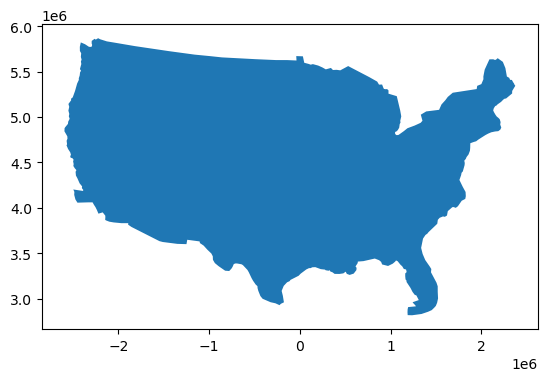

In [361]:
usa.set_precision(0.0001).to_crs(crs=CRS.from_proj4("+proj=lcc +lat_1=25 +lat_2=25 +lon_0=-95")).set_precision(1.).plot()

In [364]:
print(verfdomain_full)

POLYGON ((764419 5440725, 852497 5390950, 872398 5357473, 906326 5358724, 922577 5316564, 928652 5309608, 946646 5306902, 962108 5308577, 977050 5293160, 976681 5257850, 1068220 5230206, 1105913 5072417, 1117581 5007516, 1106378 4958550, 1109303 4940582, 1100392 4922562, 1094778 4882929, 1078738 4855648, 1064992 4842445, 1050514 4836105, 1048286 4822104, 1052606 4812790, 1058085 4805222, 1068890 4800594, 1088642 4804162, 1145381 4844657, 1185810 4877170, 1264896 4906506, 1331090 4936838, 1351190 4959310, 1332935 5026515, 1392425 5062116, 1534330 5079867, 1560529 5138741, 1603533 5186264, 1630284 5222397, 1684998 5268231, 1948503 5308614, 1954185 5344022, 1999987 5363128, 2022734 5416842, 2022105 5447258, 2036803 5522831, 2088811 5636081, 2131976 5636786, 2144155 5630907, 2159086 5630645, 2179867 5648855, 2236747 5608304, 2264741 5539678, 2281188 5446955, 2306903 5432408, 2316439 5410411, 2335957 5409260, 2351725 5381220, 2359628 5370262, 2362712 5360966, 2373979 5344803, 2339690 528789

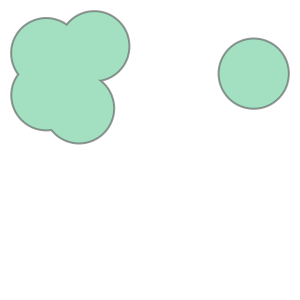

In [247]:

df1=df_wind[(df_wind.datetime<='2025-10-29 12:00:00')&(df_wind.datetime>='2025-10-28 12:00:00')].sort_values(by='datetime').copy()
gdflatlon = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.slon, df1.slat)).set_crs(epsg=4326)
gdf = gdflatlon.to_crs('epsg:4087')
obsarea_full=shp.set_precision(shp.union_all(gdf.buffer(40000.)),grid_size=100.)
obsarea_full

In [375]:
ds_mrms.coarsen(latitude=3,longitude=3,boundary='pad').mean()

<xarray.Dataset> Size: 2MB
Dimensions:     (y: 226, x: 387)
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
    latitude    (y, x) float64 700kB 19.86 19.89 19.92 ... 49.83 49.8 49.77
    longitude   (y, x) float64 700kB 234.9 235.0 235.2 ... 299.5 299.6 299.8
    valid_time  datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Data variables:
    windprob    (y, x) float32 350kB 0.000189 0.000189 ... 0.000189 0.000189
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2026-02-20T14:53 GRIB to CDM+CF via cfgrib-0.9.1...

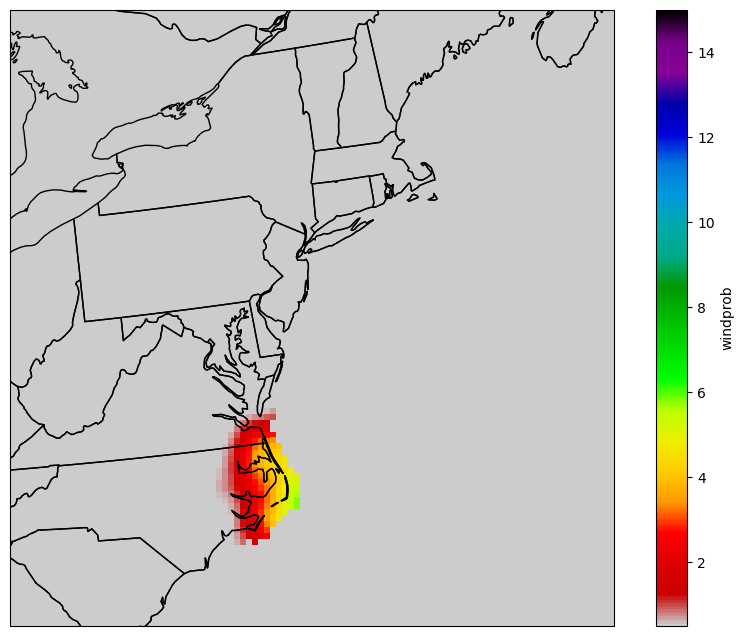

In [380]:
import matplotlib.colors as colors
wofs_lon=ds_mlp.longitude.values
wofs_lat=ds_mlp.latitude.values
wofs_wind=ds_mlp.windprob.values
conus1=ds_mask.CONUS.values
#wofs_lon=ds_mlp.coarsen(y=3,x=3,boundary='pad').mean().longitude.values
#wofs_lat=ds_mlp.coarsen(y=3,x=3,boundary='pad').mean().latitude.values
#wofs_wind=ds_mlp.coarsen(y=3,x=3,boundary='pad').mean().windprob.values
#conus1=ds_mask.coarsen(y=3,x=3,boundary='pad').max().CONUS.values
wofs_wind=wofs_wind*conus1
# Set up plot crs (mapcrs) and the data crs, will need to transform all variables

mapcrs = ccrs.LambertConformal(central_longitude=-95., central_latitude=0.,
                               standard_parallels=(25., 25.))
datacrs = ccrs.PlateCarree()

clevs = np.arange(0, 1.01, 0.1)



# Start figure
fig = plt.figure(1, figsize=(11, 8))


ax1 = plt.subplot(projection=mapcrs)

ax1.set_extent([-82.,-67.,33.,45.], ccrs.PlateCarree())

ax1.add_feature(cfeat.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeat.STATES.with_scale('50m'))

cmap = colors.ListedColormap(['#e4ffff','#afe2ff','#7db1e3','#4a81b1','#fee0d2','#fcbba1','#fc9272','#fb6a4a','#ef3b2c','#cb181d'])
mesh=ax1.pcolormesh(wofs_lon,wofs_lat,wofs_wind,transform=datacrs,cmap='nipy_spectral_r',vmin=0.5,vmax=15.)
plt.colorbar(mesh,ax=ax1,orientation='vertical',label='windprob')
#plt.scatter(wofs_lon[np.logical_not(active_wofs)],wofs_lat[np.logical_not(active_wofs)],marker='o',s=2,c='grey',transform=datacrs)
#plt.scatter(wofs_lon[wofs_ef1>0.5],wofs_lat[wofs_ef1>0.5],s=1,c='#ff08e8',marker='o',transform=datacrs,alpha=0.5)
#plt.contourf(wofs_lon,wofs_lat,wofs_ef1,colors='#ff08e8',levels=[0.5,1.5],transform=datacrs,alpha=0.5)

#paths_plot[paths_plot.TOR_F_SCALE=='EF0'].plot(ax=ax1, transform=mapcrs, color='orange', label='EF0')
#paths_plot[paths_plot.TOR_F_SCALE=='EF1'].plot(ax=ax1, transform=datacrs, color='blue', label='EF1',zorder=5)
#paths_plot[paths_plot.TOR_F_SCALE=='EF2'].plot(ax=ax1, transform=datacrs, color='black', label='EF2',zorder=5)

#paths_plot[paths_plot.TOR_F_SCALE=='EF3'].plot(ax=ax1, transform=mapcrs, color='yellow', label='EF3')
#paths_plot[paths_plot.TOR_F_SCALE=='EF4'].plot(ax=ax1, transform=mapcrs, color='red', label='EF4')
#points_in_polygon.dropna().buffer(3000.).plot(ax=ax1, transform=mapcrs, edgecolor='none', facecolor='lightgray')
#points_in_polygon.dropna(subset=['BEGIN_DAY']).plot(ax=ax1, transform=mapcrs, edgecolor='pink', facecolor='lightgray')
#gdfgrd.plot(ax=ax1, transform=mapcrs,facecolor='lightgray',edgecolor='pink')
#plt.legend()
#plt.title(f'WoFS 2023-03-31 1700 run 05h fcst valid 2023-03-31 2200 9km NMEP', loc='left')


In [377]:
ds_mlp.coarsen(x=3,y=3,boundary='pad').mean()

<xarray.Dataset> Size: 196kB
Dimensions:     (y: 76, x: 129)
Coordinates:
    time        datetime64[ns] 8B 2025-09-15
    step        timedelta64[ns] 8B 1 days 11:00:00
    surface     float64 8B 0.0
    latitude    (y, x) float64 78kB 20.02 20.11 20.2 20.29 ... 49.99 49.89 49.8
    longitude   (y, x) float64 78kB 235.0 235.4 235.9 ... 298.5 299.1 299.6
    valid_time  datetime64[ns] 8B 2025-09-16T11:00:00
Dimensions without coordinates: y, x
Data variables:
    windprob    (y, x) float32 39kB 0.000189 0.000189 ... 0.000189 0.000189
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2026-02-20T14:53 GRIB to CDM+CF via cfgrib-0.9.1...

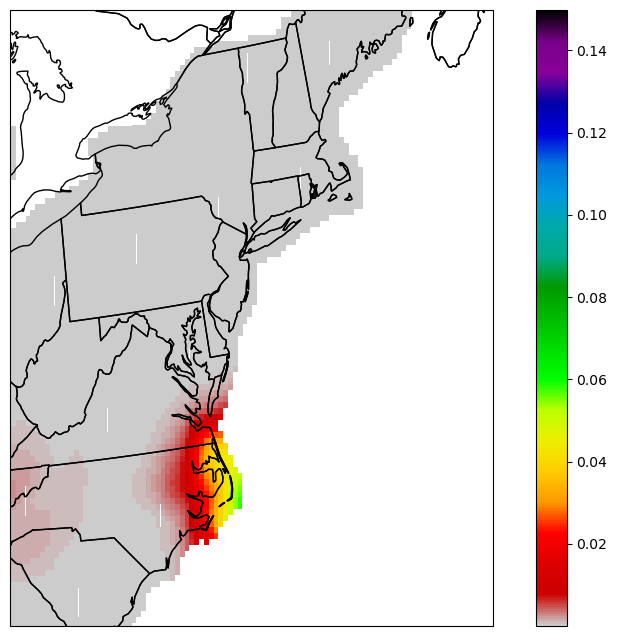

In [381]:
import matplotlib.colors as colors

wofs_lon=ds_mlp.longitude.values
wofs_lat=ds_mlp.latitude.values
wofs_wind=ds_mlp.windprob.values
conus1=ds_mask.CONUS.values
wofs_wind=wofs_wind*conus1
# Set up plot crs (mapcrs) and the data crs, will need to transform all variables

mapcrs = ccrs.LambertConformal(central_longitude=-95., central_latitude=0.,
                               standard_parallels=(25., 25.))
datacrs = ccrs.PlateCarree()

clevs = np.arange(0, 1.01, 0.1)



# Start figure
fig = plt.figure(1, figsize=(11, 8))


ax1 = plt.subplot(projection=mapcrs)

ax1.set_extent([-82.,-67.,33.,45.], ccrs.PlateCarree())

ax1.add_feature(cfeat.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeat.STATES.with_scale('50m'))

cmap = colors.ListedColormap(['#e4ffff','#afe2ff','#7db1e3','#4a81b1','#fee0d2','#fcbba1','#fc9272','#fb6a4a','#ef3b2c','#cb181d'])
#mesh=ax1.pcolormesh(wofs_lon,wofs_lat,wofs_wind,transform=datacrs,cmap=cmap,vmin=0.0,vmax=30.)
#plt.colorbar(mesh,ax=ax1,orientation='vertical',label='windprob')
mesh=hwgrdproj[hwgrdproj.conus>0.].to_crs('epsg:4326').plot('mlp',cmap='nipy_spectral_r',transform=datacrs,ax=ax1,legend=True)
#plt.scatter(wofs_lon[np.logical_not(active_wofs)],wofs_lat[np.logical_not(active_wofs)],marker='o',s=2,c='grey',transform=datacrs)
#plt.scatter(wofs_lon[wofs_ef1>0.5],wofs_lat[wofs_ef1>0.5],s=1,c='#ff08e8',marker='o',transform=datacrs,alpha=0.5)
#plt.contourf(wofs_lon,wofs_lat,wofs_ef1,colors='#ff08e8',levels=[0.5,1.5],transform=datacrs,alpha=0.5)

#paths_plot[paths_plot.TOR_F_SCALE=='EF0'].plot(ax=ax1, transform=mapcrs, color='orange', label='EF0')
#paths_plot[paths_plot.TOR_F_SCALE=='EF1'].plot(ax=ax1, transform=datacrs, color='blue', label='EF1',zorder=5)
#paths_plot[paths_plot.TOR_F_SCALE=='EF2'].plot(ax=ax1, transform=datacrs, color='black', label='EF2',zorder=5)

#paths_plot[paths_plot.TOR_F_SCALE=='EF3'].plot(ax=ax1, transform=mapcrs, color='yellow', label='EF3')
#paths_plot[paths_plot.TOR_F_SCALE=='EF4'].plot(ax=ax1, transform=mapcrs, color='red', label='EF4')
#points_in_polygon.dropna().buffer(3000.).plot(ax=ax1, transform=mapcrs, edgecolor='none', facecolor='lightgray')
#points_in_polygon.dropna(subset=['BEGIN_DAY']).plot(ax=ax1, transform=mapcrs, edgecolor='pink', facecolor='lightgray')
#gdfgrd.plot(ax=ax1, transform=mapcrs,facecolor='lightgray',edgecolor='pink')
#plt.legend()
#plt.title(f'WoFS 2023-03-31 1700 run 05h fcst valid 2023-03-31 2200 9km NMEP', loc='left')


In [383]:
lvls

array([0.0e+00, 1.0e-04, 1.0e-03, 1.0e-02, 2.0e-02, 5.0e-02, 1.0e-01,
       1.5e-01, 2.0e-01, 2.5e-01, 3.0e-01, 4.5e-01, 6.0e-01, 1.0e+00])

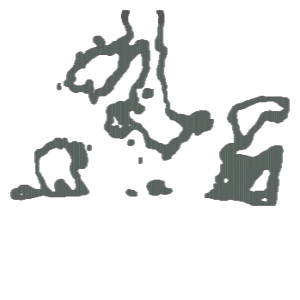

In [393]:
shp.union_all(hwgrdproj[(hwgrdproj.mlp>=0.001)&(hwgrdproj.mlp<0.01)].geometry,grid_size=1.)

In [341]:
print(hwgrdproj[hwgrdproj.mlp>10.].iloc[0].geometry)

POLYGON ((2363030 3292130, 2347793 3292130, 2347793 3307367, 2363030 3307367, 2363030 3292130))


In [342]:
print(hwgrdproj[hwgrdproj.mlp>10.].iloc[1].geometry)

POLYGON ((2378291 3292144, 2363054 3292144, 2363054 3307381, 2378291 3307381, 2378291 3292144))


In [343]:
hwgrdproj[hwgrdproj.mlp>10.].iloc[90:111].area

23194    232166169.0
23195    232166169.0
23196    232166169.0
23197    232166169.0
23198    232166169.0
23579    232166169.0
23580    232166169.0
23581    232166169.0
23582    232166169.0
23583    232166169.0
23584    232166169.0
23585    232166169.0
23967    232166169.0
23968    232166169.0
23969    232166169.0
23970    232166169.0
23971    232166169.0
23972    232166169.0
24354    232166169.0
24355    232166169.0
24356    232166169.0
dtype: float64

In [339]:
ds_mask=xr.open_dataset('/users/baldwin/data/CONUS_nadocast.nc')
conus_grid=ds_mask.CONUS.values
xx_mlp=np.arange(387)
yy_mlp=np.arange(226)
Xhw,Yhw=np.meshgrid(xx_mlp,yy_mlp)
X1dhw=Xhw.flatten()
Y1dhw=Yhw.flatten()
lat2d=ds_mask.latitude.values
lon2d=ds_mask.longitude.values-360.0
df_hwgrd=pd.DataFrame({'col':X1dhw,'row':Y1dhw,'conus':conus_grid.flatten(),'lon':lon2d.flatten(),'lat':lat2d.flatten()})
hwgrdlatlon = gpd.GeoDataFrame(df_hwgrd, geometry=gpd.points_from_xy(df_hwgrd.lon, df_hwgrd.lat)).set_crs(epsg=4326)
hwgrdproj=hwgrdlatlon.to_crs(crs=CRS.from_proj4("+proj=lcc +lat_1=25 +lat_2=25 +lon_0=-95"))
hwgrdproj['geometry']=hwgrdproj.buffer(7618.5,cap_style='square').set_precision(1.)
#hwgrdproj['geometry']=hwgrdproj.to_crs('epsg:4087').set_precision(1.)
hwgrdproj['mlp']=ds_mlp.windprob.values.flatten()
#hwgrd = hwgrdproj.to_crs('epsg:4087').set_precision(100.)

In [200]:
hwgrdproj['geometry']=hwgrdproj.to_crs('epsg:4087').set_precision(100.)

KeyError: 'mlp'

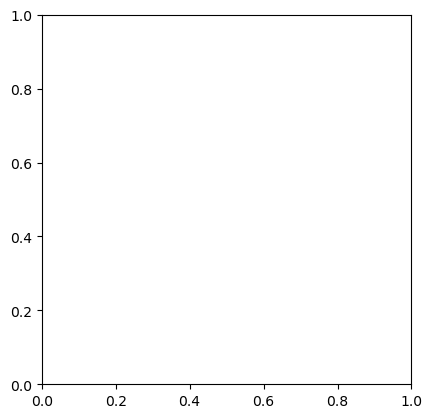

In [201]:
hwgrdproj.plot('mlp')

In [202]:
hwgrdproj['mlp']=ds_mlp.windprob.values.flatten()

In [203]:
hwgrdproj

,col,row,conus,lon,lat,geometry,mlp
0,0,0,0.0,-125.094000,19.858000,"POLYGON ((-13915800 2204800, -13931500 2201500...",0.000191
1,1,0,0.0,-124.952418,19.887978,"POLYGON ((-13900000 2208100, -13915700 2204800...",0.000191
2,2,0,0.0,-124.810769,19.917819,"POLYGON ((-13884200 2211500, -13900000 2208100...",0.000191
3,3,0,0.0,-124.669054,19.947522,"POLYGON ((-13868500 2214800, -13884200 2211400...",0.000191
4,4,0,0.0,-124.527273,19.977087,"POLYGON ((-13852700 2218000, -13868400 2214700...",0.000191
...,...,...,...,...,...,...,...
87457,221,386,0.0,-60.911341,49.894588,"POLYGON ((-6773000 5545900, -6793500 5549300, ...",0.000191
87458,222,386,0.0,-60.726109,49.863839,"POLYGON ((-6752400 5542500, -6772900 5545900, ...",0.000191
87459,223,386,0.0,-60.541007,49.832918,"POLYGON ((-6731800 5539000, -6752300 5542500, ...",0.000191
87460,224,386,0.0,-60.356036,49.801826,"POLYGON ((-6711200 5535500, -6731700 5539000, ...",0.000191


ValueError: 'mlp' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

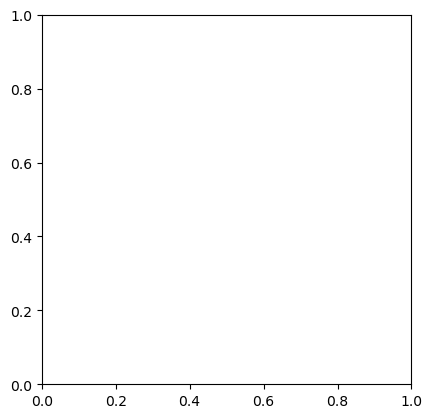

In [204]:
hwgrd.set_precision(100.).plot('mlp')